🦁 Welcome to the whimsical world of Farcaster's social network analysis, straight from the belly of the Dune platform! 

🦒 Through `Dune’s API`, we’ve summoned the Farcaster data into our Pythonic cauldron, brewing a network graph that will reveal the social dynamics at play.

🦓 In today's digital exploration, we delve first into **summary statistics** to get some general idea about the Farcaster network in the past one month.

🐒 Then we we use a few **centrality measurements** to understand who the most influential users are in this network. Spoiler Alert: No drumroll needed for the star of our show - dwr.eth aka Dan, the maestro behind Farcaster, who's reigning over all centrality measures. 

🐘 Finally, we conduct **community detection**. We introduce sampling methods that will help us make sense of the massive web of connections. It’s like taking a manageable snapshot before diving into the bustling social city that is Farcaster.


🐅 We hope this notebook not only serves as your telescope into Farcaster’s universe but also gives an example of how to export data from Dune for network analysis. 

🦏 So gear up, let's dive into the numbers, graphs, and the subtle art of finding who’s who in the Farcaster zoo!

### _note: all the Farcaster data is taken 1 month from time of writing, Oct 23, 2023._

_P.S. Yes I used ChatGPT to help me write this intro :p_

## Import libraries

In [1]:
import sys
!{sys.executable} -m pip install pandas networkx python-louvain matplotlib plotly python-dotenv nltk dune-client


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [2]:
import pandas as pd 
import networkx as nx 
import community as community_louvain
from networkx import community
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import dotenv, os, json
from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase
from multiprocessing import Pool
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import random
import itertools
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## Environment setup

In [4]:
query_result = pd.read_csv("Farcaster_Centrality_Measures_Weighted_2023_10_31.csv")

## Import dataset from Dune as Excel

#### Option 1: query the query (run the execution)

In [5]:
# query = QueryBase(
#     name="Farcaster Centrality Measures",
#     query_id=3078764,
#     params=[
#         # Here we can play with different weights we are assigning to each type of reaction in this directed graph
#         QueryParameter.number_type(name="follow_points", value=5),
#         QueryParameter.number_type(name="like_points", value=1),
#         QueryParameter.number_type(name="recast_points", value=3),
#         QueryParameter.number_type(name="reply_points", value=2),
#         QueryParameter.number_type(name="past_n_months", value=1),
#     ],
# )
# query_result = dune.run_query_dataframe(query=query, performance="large") # specify large cluster for faster runtime

## Construct the graph
Let's build a directed `networkx` graph from the edgelist in query_result:

In [6]:
G = nx.from_pandas_edgelist(query_result, 
                            source='from_user',
                            target='to_user',
                            edge_attr='total_points',
                            create_using=nx.DiGraph())

In [7]:
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))

Number of nodes 25882
Number of edges 2342339


---
## <span style="color:red;">Summary Statistics</span> 

Let's first look at a few summary statistics to get a general idea about the Farcaster network.

### 1. Density
$$ 
\text{Density} = \frac{\text{Number of Edges}}{\text{Number of Possible Edges}} 
$$

- **Interpretation**: 
    - A **low density** indicates that nodes are not highly interconnected, signifying a sparse network. 
    - A **high density** suggests a well-interconnected network, indicating a web of many interactions between the nodes.
    - A density of 1 (or 100%) indicates a complete graph, where every node is connected to every other node.
    - A density of 0 indicates a graph with no edges.
    - In many real-world networks, especially those that are large, densities tend to be quite low because not all nodes are directly connected to all other nodes.
    - General guideline on what is high, moderate, or low density:
        - High Density: Closer to 1 - implies most nodes are connected to each other.
        - Moderate Density: Around 0.5 - implies a fair amount of connections between nodes.
        - Low Density: Closer to 0 - implies sparser connections among nodes.

In [8]:
density = nx.density(G)
print(f"Density: {density:.4f}")

Density: 0.0035


With a low density, we can say that current Farcaster network in general is quite sparse, meaning users in the network tend not to be directly connected to many other users. It's not uncommon in large social networks, such as the entire Farcaster network we are looking at, to have a low density. 

Large networks often require a more granular approach to understand local sub-network structures or clusters, as they might have different properties compared to the global network. We will look at this later.

---
### 2. Average Degree
$$
\text{Average Degree} = \frac{\sum \text{Degree of all nodes}}{\text{Number of Nodes}} 
$$

- **Interpretation**: 
    - The **average degree** provides a snapshot into the typical interconnectedness of nodes within the graph. 
    - A **higher average degree** implies that nodes tend to have more connections, suggesting a user generally interacts with numerous other users.

In [9]:
avg_degree = sum(dict(G.degree()).values()) / float(len(G.nodes))
print(f"Average Degree: {avg_degree:.4f}")

Average Degree: 181.0014


On the surface, the average degree 52 is low compared to the total number of nodes, which is 18,030. This means that on average, a node is connected or have interacted with 52 other nodes in the last month, which suggests that Farcaster network is not very interconnected.

Let's also check the distribution. In real networks, distribution of degree is often heavily skewed, which renders the average to not be very informative.

---
### graph distributions of degree, in-degree, out-degree

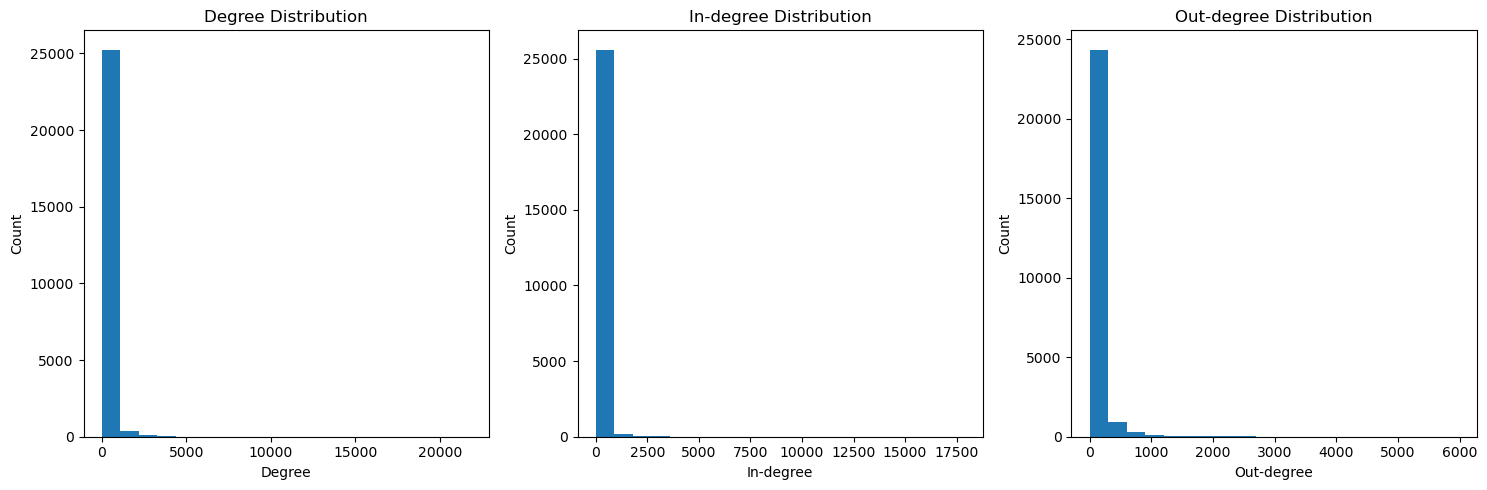

In [10]:
# Degree Distributions
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)

# Plotting the distributions
plt.figure(figsize=(15, 5))

# Total Degree Distribution
plt.subplot(1, 3, 1)
plt.hist(degree_sequence, bins=20)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")

# In-degree Distribution
plt.subplot(1, 3, 2)
plt.hist(in_degree_sequence, bins=20)
plt.title("In-degree Distribution")
plt.xlabel("In-degree")
plt.ylabel("Count")

# Out-degree Distribution
plt.subplot(1, 3, 3)
plt.hist(out_degree_sequence, bins=20)
plt.title("Out-degree Distribution")
plt.xlabel("Out-degree")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

As suspected, the degree distribution is heavily skewed, indicating that very few nodes have an extraordinarily high degree. So we should further investigate hubs and connected components.  

---

### 3. Connected Components
In directed graphs (DiGraph), we typically consider strongly connected components, which are subgroups where every node is accessible from every other node within the subgroup.

- **Interpretation**: 
    - A **greater number** of connected components suggests more isolated sub-networks within the graph, which might indicate less overall cohesion in the network.
    - Understanding why the network disintegrates into multiple components may provide insights into potential barriers restricting interaction between the components.

In [11]:
num_strongly_conn_comp = nx.number_strongly_connected_components(G)
print(f"Number of Strongly Connected Components: {num_strongly_conn_comp}")

Number of Strongly Connected Components: 5462


With 9,071 strongly connected components in a network of 18,030 nodes, Farcaster network exhibits a substantial segmentation into isolated clusters, suggesting that robust, bidirectional interactions are localized within these subgroups, potentially reflecting inherent divisions (e.g., by topic or interest) among entities.

---
## <span style="color:red;">Centrality</span>

Next, let's look at a few various centrality measures to understand influence in the Farcaster network.

---
### **Degree Centrality**
Time Complexity: O(n)

   - **Definition**: Measures the number of edges connected to a node.
   - **Formula**: 
     $$
     C_D(v) = \frac{{\text{{degree}}(v)}}{{|N| - 1}}
     $$
     where \(C_D(v)\) is the degree centrality of node \(v\), \(\text{{degree}}(v)\) is the degree of \(v\), and \(|N|\) is the total number of nodes.
   - **Implication**: Nodes with higher degree centrality are more connected to others and might have higher influence or access within the network.

In [12]:
degree_centrality = nx.degree_centrality(G)
top_10_degree_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]
top_10_degree_values = {node: degree_centrality[node] for node in top_10_degree_nodes}

print("Top 10 by Degree Centrality:")
print()
for node, centrality in top_10_degree_values.items():
    print(f"{node}: {centrality}")

Top 10 by Degree Centrality:

dwr.eth: 0.842741779683938
v: 0.6229280166917817
phil: 0.6189482632046676
greg: 0.5930219079633708
cassie: 0.5905490514276883
cameron: 0.5840964414048917
jessepollak.eth: 0.5791120899501565
linda: 0.5780302152157955
tim: 0.5721958193269194
pugson: 0.5709593910590781


👉 `dwr.eth`, `komarick`, `cryptopavlov` are the most influential people in Farcaster network beacause they have the most exposure. However, because degree centrality is a local measure, result can be deceiving. So let's move onto other centrality measures.

### **Betweenness Centrality**

Time Complexity: O(nm) and can be O(nm + n^2 log n) in the worst case. 

_WARNING: This can be computationally expensive for large networks. You can approximate it by using a subset of nodes._

   - **Definition**: Quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
   - **Formula**: 
     $$
     C_B(v) =\sum_{s,t \in V} \frac{{\sigma(s, t|v)}}{{\sigma(s, t)}}
     $$
     where \(V\) is the set of nodes, \(\sigma(s, t)\) is the number of shortest \((s, t)\)-paths, and \(\sigma(s, t|v)\) is the number of those paths passing through node \(v\).
   - **Implication**: Nodes with high betweenness centrality have greater control over information flow and can connect disparate parts of the network.

In [ ]:
%%time
# Use a sample of nodes to estimate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True) # can add k=1000 when optimization is needed
top_10_betweenness_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]
top_10_betweenness_values = {node: betweenness_centrality[node] for node in top_10_betweenness_nodes}


print("Top 10 by Betweenness Centrality:")
print()
for node, centrality in top_10_betweenness_values.items():
    print(f"{node}: {centrality}")

👉 `dwr.eth`, `survey`, `cojo.eth` have the most control over information flow, meaning that they can connect a rather disconnected graph (which we know is the case from having 9071 strongly connected components, aka segmented network). So if you want to distribute information (like promoting or marketing), you should go partner up with these people.

### **Closeness Centrality**


Time Complexity: O(n(m + n log n)) - also can be computationally expensive

_Optionally use a subset_

   - **Definition**: Measures the average shortest path between a node and all other nodes in the graph.
   - **Formula**: 
     \[
     C(x) = \frac{{n-1}}{{\sum_{y}d(y,x)}}
     \]
     where \(n\) is the number of nodes in the connected part of graph containing \(x\) and \(d(y, x)\) is the distance between vertices \(x\) and \(y\).
   - **Implication**: Nodes with higher closeness centrality can disseminate information more efficiently due to their proximity to all other nodes.

In [ ]:
%%time 
closeness_centrality = nx.closeness_centrality(G)
top_10_closeness_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:10]
top_10_closeness_values = {node: closeness_centrality[node] for node in top_10_closeness_nodes}

print("Top 10 by Closeness Centrality:")
print()
for node, centrality in top_10_closeness_values.items():
    print(f"{node}: {centrality}")

👉 `dwr.eth`, `vitalik.eth`, `v` can disseminate information more efficiently due to their proximity to all other users.

### **Eigenvector Centrality**

Time Complexity: O(n^2)

_Can run fairly efficiently on your size of graph depending on the iteration settings_

   - **Definition**: Assigns relative scores to all nodes in the network based on the principle that connections to nodes with high scores contribute more to the score of the node.
   - **Formula**: 
     Let \(A\) be the adjacency matrix of the graph G, \(x\) be the eigenvector, and $\lambda$ be the eigenvalue. Eigenvector centrality solves
     $$
     Ax = \lambda x
     $$
   - **Implication**: It implies influence; a node is considered important if it is linked to by other important nodes.

In [ ]:
%%time 
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=200)

top_10_eigenvector_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:10]
top_10_eigenvector_values = {node: eigenvector_centrality[node] for node in top_10_eigenvector_nodes}

print("Top 10 by Eigenvector Centrality:")
print()
for node, centrality in top_10_eigenvector_values.items():
    print(f"{node}: {centrality}")

👉 `dwr.eth`, `vitalik.eth`, `nonlinear.eth` are the most important note when we take into consideration of how influential their connections are. For example, being connected and having influence over the Provost and the Chancellor can make you arguably more important than being connected to all of the university's graduate TAs.

### **PageRank**

Time Complexity: O(n log n + m)

_Generally tolerable on large graphs due to its logarithmic nature._

   - **Definition**: Assigns a ranking of nodes based on the structure of incoming links. It’s iterative and assumes an object's importance is determined by the importance of the objects that link to it.
   - **Formula**: 
     Let \(PR(p_i)\) be the PageRank of page \(i\), \(N\) be the total number of pages, \(d\) be a damping factor, \(L(p_j)\) be the number of outbound links on page \(j\) and \(P\) be the set of all pages.
     $$
     PR(p_i) = \frac{{1-d}}{N} + d \sum_{p_j \in M(p_i)} \frac{{PR(p_j)}}{{L(p_j)}}
     $$
   - **Implication**: Nodes with higher PageRank are more important. Helps identify most influential nodes in the network.

In [ ]:
%%time 
pagerank = nx.pagerank(G, alpha=0.85)
# A higher alpha (closer to 1) means the walker is more likely to continue along its current path, attributing more importance to the immediate neighborhood structure. 
# A lower alpha (closer to 0) lessens the impact of the immediate neighborhood and makes the rank more uniform because the walker is more likely to jump to random nodes.

In [ ]:
top_10_pagerank_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:10]
top_10_pagerank_values = {node: pagerank[node] for node in top_10_pagerank_nodes}

print("Top 10 by PageRank:")
print()
for node, centrality in top_10_pagerank_values.items():
    print(f"{node}: {centrality}")

👉 Using what Google uses to display search result, another way to measure the most important users in the network, which here means `dwr.eth`, `vitalik.eth`, and `ted`. 

---
### <span style="color:red;"> Visualizing the network</span>

#### 1. Gephi
- Go to https://gephi.org/ and download Gephi
- Export the graph out to Gephi to visualize it and play with it

#### Export to gml format to see in Gephi

In [ ]:
nx.write_gml(G, "FC_centrality_L1M.gml")

- Farcaster Last Month Graph Zoomed Out screenshot:
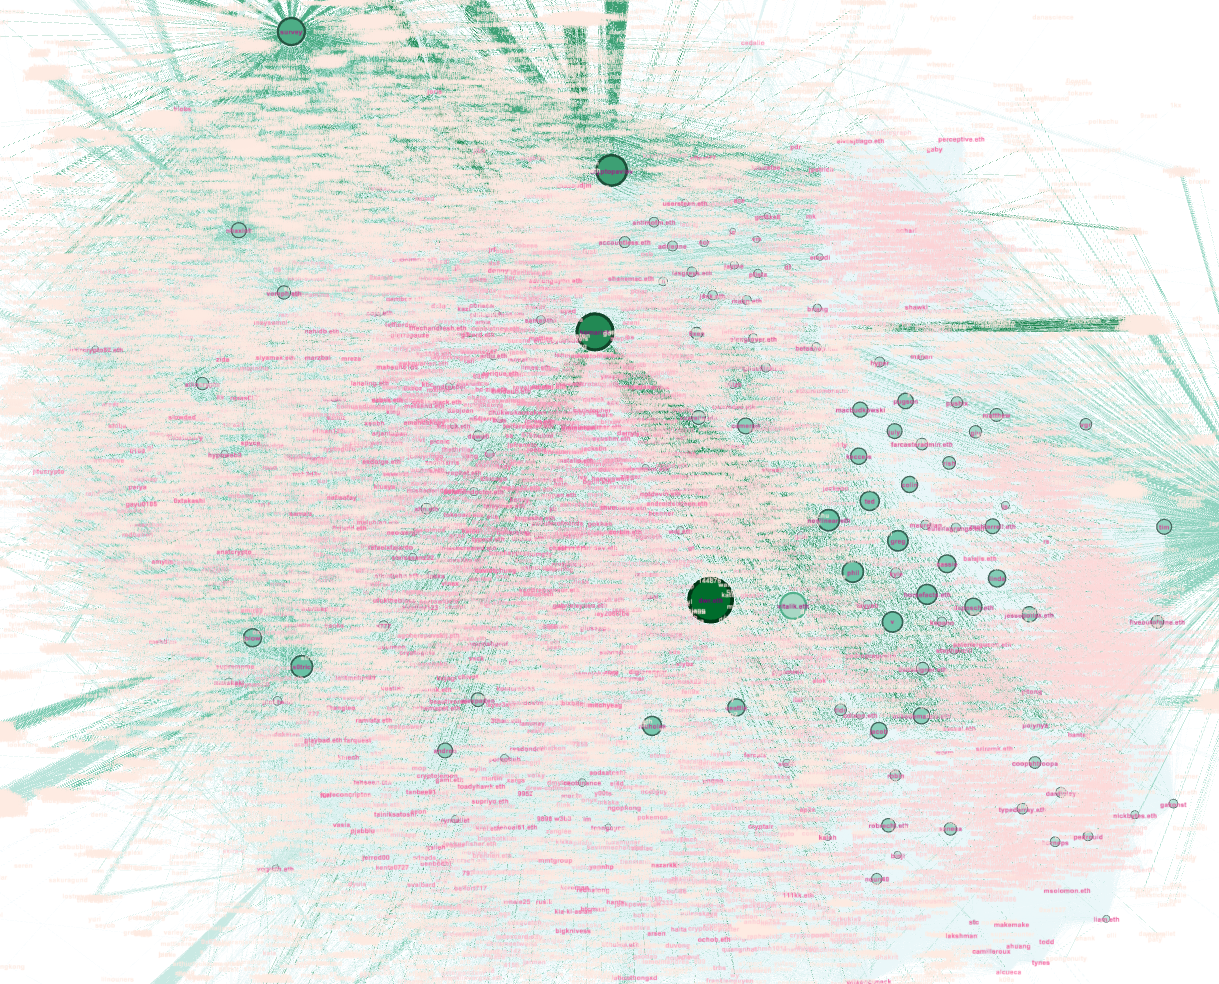
    - Here, the node size and label color are all dictated by the degree. The higher the degree the bigger the circle is; the higher the degree the more red the label is. 

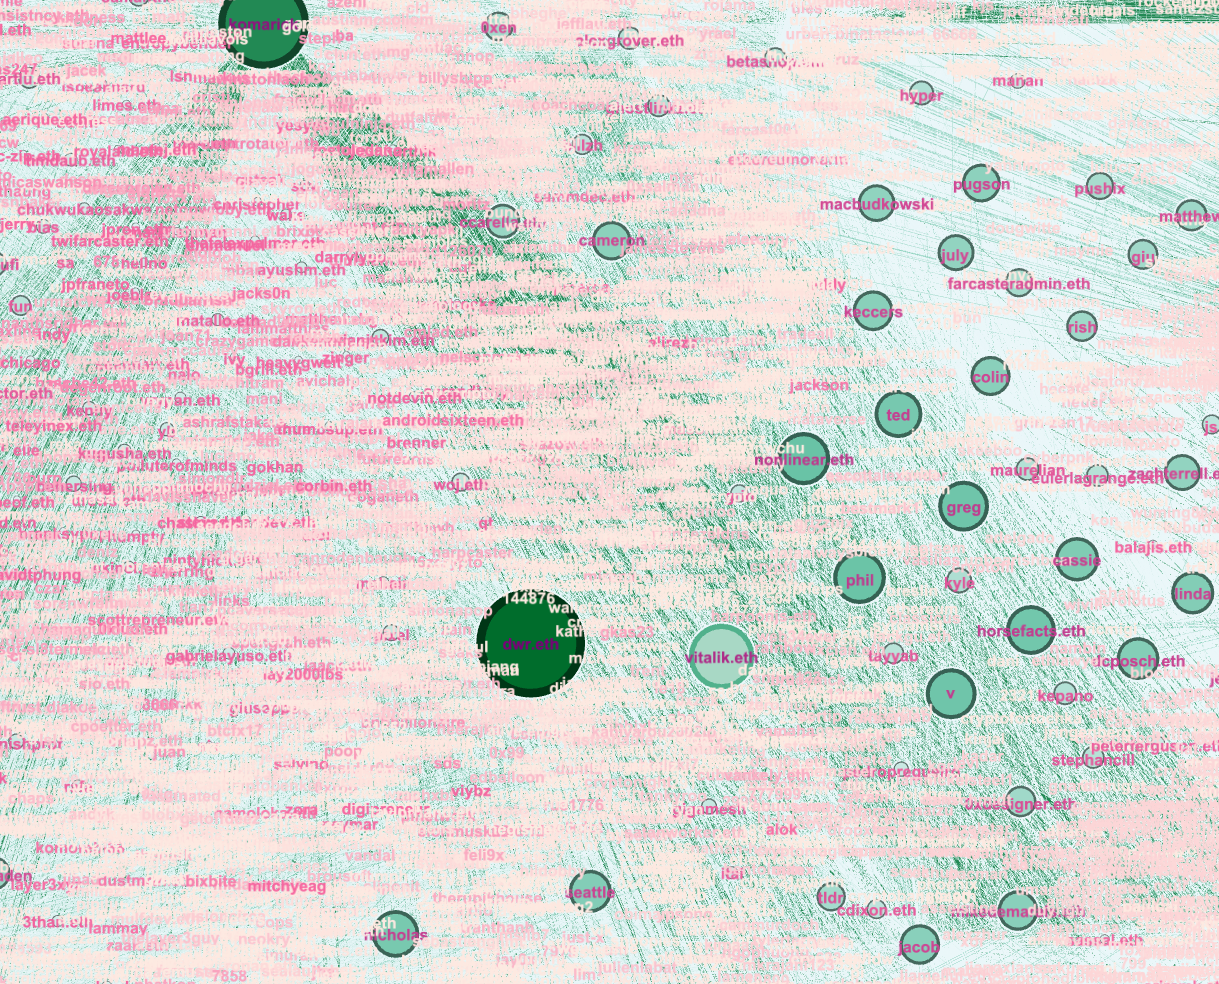
    - zooming in, we can clearly see some of the important nodes we've discovered from centrality measures before, such as `dwr.eth`, `nonlinear.eth` and `vitalik.eth`

#### 2. In Python with NetworkX or Plotly for interactive graph
- With such a large network like Farcaster, we won't be able to visualize all the nodes and edges like we could in Gephi. So here we will just visulize the top 200 nodes in terms of degree. 
- So below, for both static and interactive plot, I've tried to use color to represent out-degree -- so if a user or node is more blue, that means they don't follow or comment or recast as much as the users who are more red. 
- The size of the node or user represents the in-degree, meaning the connections and interactions they receive.
- So if someone's circle is relatively small but it's relatively more red, that means they have more outbound activities than inbound activities. 

In [ ]:
G_saved = G.copy() # backing up just in case

In [ ]:
G = G_saved.copy()

In [ ]:
# 1. Check the total number of nodes in the graph
print(f"Total nodes before filtering: {G.number_of_nodes()}")
print(f"Total edges before filtering: {G.number_of_edges()}")

# 2. Sort nodes by degree in descending order
sorted_nodes = sorted(G.nodes(), key=lambda n: G.degree(n), reverse=True)

# Keep top 500 nodes
nodes_to_keep = sorted_nodes[:200]
nodes_to_remove = sorted_nodes[200:]

# Remove nodes beyond the top 200
for node in nodes_to_remove:
    G.remove_node(node)

print(f"Total nodes after filtering: {G.number_of_nodes()}")
print(f"Total edges after filtering: {G.number_of_edges()}")

In [ ]:
%%time

# Layout
pos = nx.spring_layout(G)

# Node Colors (heatmap-style based on out-degree)
out_degrees = [G.out_degree(n) for n in G.nodes()]
max_out_degree = max(out_degrees)
colors = plt.cm.coolwarm([d/max_out_degree for d in out_degrees])

# Adjusting alpha for visibility
alpha_values = [0.7 + 0.3 * (d/max_out_degree) for d in out_degrees]

# Node Sizes (based on in-degree)
in_degrees = [G.in_degree(n) for n in G.nodes()]
size_factor = 10  # adjust this value to fit your needs
sizes = [d * size_factor for d in in_degrees]

# Set the figure size
plt.figure(figsize=(15, 10))

# Draw Nodes and Edges
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=alpha_values) 
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)  # Set edge color to gray or any distinct color you prefer
nx.draw_networkx_labels(G, pos)  # Optional: if you want labels on nodes

plt.title("Top 200 influential users in Farcaster network")
plt.show()


In [ ]:
%%time

# Layout
pos = nx.kamada_kawai_layout(G)

# Node Colors (heatmap-style based on out-degree)
out_degrees = [G.out_degree(n) for n in G.nodes()]
max_out_degree = max(out_degrees)
colorscale = [[0, 'blue'], [1, 'red']]
node_colors = [d/max_out_degree for d in out_degrees]

# Node Sizes (adjusted for better visibility)
size_factor = 0.5
sizes = [d * size_factor + 5 for d in in_degrees]  # Added a constant to ensure even nodes with 0 in-degrees are visible

# Edge coordinates for plotting
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Node coordinates for plotting
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Node Labels
labels = list(G.nodes())

# Create the plot using Plotly
edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(color='gray', width=0.5), opacity=0.7)
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text', marker=dict(size=sizes, color=node_colors, colorscale=colorscale, showscale=True, opacity=0.8), text=labels, textposition="top center", hoverinfo='text')

fig = go.Figure(data=[edge_trace, node_trace])

# Adjusting layout for better visualization
fig.update_layout(showlegend=False, hovermode='closest', width=1000, height=1000)

fig.show()


🔎👉 So zooming in, we see that `briang` has larget circle than `n` but it's blue color where as `n` is red. We can interpret this as `briang` has more inbound activities and `n` has more outbound activities in the last month. 

---
⏭️ Next, we will move on to community detection. 

Community detection in network analysis is about finding groups of nodes that interact more with each other than with the rest of the network, revealing underlying structures. By identifying these communities, we can better understand how information or behaviors spread within a network. It’s a key step for targeted actions like marketing campaigns, as well as for spotting trends, influential nodes, and the overall dynamics of the network.

However, because the network we have at hand is quite large, we will need to first do some sampling. 

---
## <span style="color:red;">Sampling</span>

Sampling in large social network analysis is like taking a manageable snapshot of a bustling city, saving us time and computing resources while still providing a sharp insight into trends and key players. It's our shortcut to making sense of the massive web of connections without getting overwhelmed by the data deluge.

There are many ways to sample, below we show two ways and define helper functions as well. 

### Random Node Sampling (RNS)

In this method, you randomly pick nodes from the network, making it a straightforward way to get a quick snapshot. Each node has an equal chance of being picked, making it fair, but it might miss out on capturing some network structures.

In [ ]:
def random_node_sampling(graph, num_nodes, seed=None):
    if seed is not None:
        random.seed(seed)  # Set the random seed if provided
        
    sampled_nodes = random.sample(graph.nodes(), num_nodes)
    return graph.subgraph(sampled_nodes)

### Random Walk Sampling (RWS)
This one’s a bit more adventurous. Starting from a random node, it takes a 'walk' along the edges to other nodes, kind of like hopping from friend to friend in a social network. This method is good for exploring local structures and can provide a more connected sample of the network compared to RNS.

In [ ]:
def random_walk_sampling(graph, start_node, num_nodes, seed=None):
    if seed is not None:
        random.seed(seed)  # Set the random seed if provided

    sampled_nodes = set([start_node])
    current_node = start_node

    while len(sampled_nodes) < num_nodes:
        neighbors = list(graph.neighbors(current_node))
        
        # If there are no neighbors, backtrack to a previously visited node
        if not neighbors:
            previous_nodes = list(sampled_nodes)
            random.shuffle(previous_nodes)
            for previous_node in previous_nodes:
                neighbors = list(graph.neighbors(previous_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                    break

        # If there are neighbors, choose a random one
        else:
            current_node = random.choice(neighbors)

        sampled_nodes.add(current_node)

    return graph.subgraph(sampled_nodes)


---
## <span style="color:red;">Community Detection</span>

Now, moving onto community detection with our sampled graph. 


Louvain and Girvan-Newman are two popular methods to uncover communities in a graph, each with its distinct flavor.

### Louvain Method
Think of Louvain as a friendly neighborhood organizer. It starts small, looking at local communities, then gradually builds up to form larger communities. It's fast and great for big networks, and likes to optimize a measure called modularity to ensure that the communities it finds are tight-knit.

### Girvan-Newman Method
On the other hand, Girvan-Newman is like a cautious gardener pruning a tree. It identifies the 'bridges' or weak ties between communities and cuts them off, slowly breaking down the network into smaller, tightly connected communities. It's a bit more thorough but can take more time, especially on large networks.

Both methods are about finding groups of nodes that have more connections with each other than with the rest of the network, but while Louvain is speedy and builds from the ground up, Girvan-Newman takes its time and carefully trims down from the top.

---

Here we will define modular helper functions and define actual functions suing Louvain or Girvan-Newman method for community detection.

#### Define helper functions

In [ ]:
def draw_communities(G, partition, pos, draw):
    if not draw:
        return
    num_communities = len(set(partition.values()))
    cmap = plt.cm.get_cmap('viridis', num_communities)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=40, cmap=cmap, node_color=list(partition.values()))
    edges = nx.draw_networkx_edges(G, pos, alpha=0.5)
    label_communities(G, partition, pos)
    plt.show()

def label_communities(G, partition, pos):
    for community_id in set(partition.values()):
        member_nodes = [node for node, community in partition.items() if community == community_id]
        x, y = zip(*[pos[node] for node in member_nodes])
        plt.text(sum(x)/len(member_nodes), sum(y)/len(member_nodes), str(community_id), fontsize=15, fontweight='bold', color='red')

def get_community_stats(partition):
    num_communities = len(set(partition.values()))
    average_size = len(set(partition.keys())) / num_communities
    
    grouped = {}
    for key, value in partition.items():
        if value not in grouped:
            grouped[value] = []  # Initialize a new list if this is a new value
        grouped[value].append(key)  # Append the key to the list corresponding to its value
    
    sorted_communities = list(grouped.values())
    sorted_communities.sort(key=len, reverse=True)

    return num_communities, average_size, sorted_communities

def print_top_communities(n, sorted_communities):
    for i, community in enumerate(sorted_communities[:n]):
        print(f"Top {i+1} community:")
        print(community)
        print()  

#### Define function for Louvain method

In [ ]:
def louvain_community(G, n=3, draw=True):
    partition = community_louvain.best_partition(G)
    pos = nx.spring_layout(G)
    draw_communities(G, partition, pos, draw)
    num_communities, average_size, sorted_communities = get_community_stats(partition)
    print(f"Number of detected communities: {num_communities}")
    print(f"Average community size: {average_size:.2f} nodes\n")
    print_top_communities(n, sorted_communities)
    return sorted_communities[:n] if n else sorted_communities

#### Define function for Girvan Newman method

In [ ]:
def girvan_newman_community(G, n=3, draw=True):
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    partition_gn = {node: cid + 1 for cid, community in enumerate(top_level_communities) for node in community}
    pos = nx.spring_layout(G)
    draw_communities(G, partition_gn, pos, draw)
    num_communities, average_size, sorted_communities = get_community_stats(partition_gn)
    print(f"Number of detected communities: {num_communities}")
    print(f"Average community size: {average_size:.2f} nodes\n")
    print(f"Top {n} Communities:")
    print_top_communities(n, sorted_communities)
    return sorted_communities[:n] if n else sorted_communities

## Find communities in Farcaster

### Using dwr.eth as the starter node to do `RWS`, find communities connected to him using `Louvain` method

🚨 <span style="color:red;">Because we modified graph `G` earlier when doing visualization, we now need to revert `G` back into the saved, original copy to proceed with sampling and analysis </span> 

In [ ]:
G = G_saved.copy()

In [ ]:
result_louvain_random_walk = louvain_community(random_walk_sampling(G, "dwr.eth", 100, 3).to_undirected(), 3, True)

### Using `RNS` to sample, detect communities using `Girvan Newman` method

In [ ]:
result_gn_random_node = girvan_newman_community(random_node_sampling(G, 100, 11).to_undirected())

### Using `RNS` to sample, detect communities using `Louvain` method

In [ ]:
result_louvain_random_node = louvain_community(random_node_sampling(G, 500, 11).to_undirected())

---

ℹ️ Identifying communities in networks is a cool way to see how things are organized and who talks to whom. Once we spot these communities, we can dive deeper into understanding them better.

Check out the example below where we’ve counted the most common words used in the top three communities derived above. Using our casts data, we get to see what each group is buzzing about, showcasing how different they are in their chit-chat. (_You can see that all three groups actually include links in their casts the most, with "http" being the most frequent word in all groups._)

And this is just the start. We can also explore things like topic modeling or sentiment analysis to get a better feel for the conversations happening.

Now, with the communities in plain sight, we can go back to those centrality measures we talked about earlier to find the big players in each community. Spotting these influential nodes helps us get how info and ideas spread around, which is super handy to know.

Plus, if we’re thinking of rolling out targeted stuff like marketing campaigns, knowing our communities helps in crafting messages that hit the right note with different groups.

In [ ]:
%%time

# Create a figure and a grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 15))

for idx, result_list in enumerate(result_louvain_random_node): # replace the results here
    # Joining items and formatting string
    quoted_items = "', '".join(result_list)
    formatted_string = f"'{quoted_items}'"
    
    # Define the query
    query = QueryBase(
        name="Farcaster texts lookup by handles",
        query_id=3128246, # https://dune.com/queries/3128246
        params=[
            QueryParameter.text_type(name="farcaster_handles", value=formatted_string),
            QueryParameter.number_type(name="past_n_months", value=1),
        ],
    )
    query_result = dune.run_query_dataframe(query=query, performance="large")  # Specify large cluster for faster runtime
    
    est_credits = query_result.size/1_000 + 20 # 20 credits for large cluster
    print(f"⛽ Estimated credit consumption from this run is {est_credits:,.1f}")
    

    # Concatenating all text data from the 'text' column into a single string
    text_data = query_result['text'].str.cat(sep=' ')

    # Tokenization
    tokens = word_tokenize(text_data.lower())  # Converts to lowercase

    # Removing stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]

    # Word frequency
    word_freq = Counter(tokens)

    # Get the most common words and their counts
    words, counts = zip(*word_freq.most_common(10))
    
    # Plotting on the corresponding subplot
    axs[idx].bar(words, counts)
    axs[idx].set_xlabel('Words')
    axs[idx].set_ylabel('Frequency')
    axs[idx].set_title(f'Word Frequency Analysis - List {idx + 1}')
    
    # Set the font size of the x-axis labels
    axs[idx].tick_params(axis='x', labelsize=15)  # Change 12 to the desired font size


# Adjust the spacing between the plots
plt.tight_layout()
plt.show()